In [1]:
# conda install lightgbm

In [2]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import tensorflow as tf
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

2022-11-21 19:17:03.338947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/pritish/anaconda3/envs/jami/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df= pd.read_pickle('final_labelled_data.pkl')
df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid1_DT_M_ct,uid2_DT_M_ct,uid1_id_02_ct,uid2_id_02_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud
0,68.5,4,3417,500,42,38,1,166,65,19.0,...,1,1,0,0,1,1,1,1,1,0
1,29.0,4,7922,303,42,2,1,173,65,NaN,...,6,6,1,1,4,4,1,1,0,0
2,59.0,4,9383,389,42,58,2,178,65,287.0,...,4,4,0,0,2,2,2,2,1,0
3,50.0,4,6991,466,42,14,2,282,65,NaN,...,6,6,2,2,114,114,115,115,0,0
4,50.0,1,9262,413,42,2,1,241,65,NaN,...,1,1,1,1,1,1,1,1,0,0


In [4]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [5]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [6]:
def train_test_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [7]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [8]:
def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [9]:
print("columns with null values: ")
print(list(df.columns[df.isnull().any()]))
print('===========================================')

missing_values = missing_values_table(df)
missing_values[:].style.background_gradient(cmap='Reds')

columns with null values: 
['dist1', 'D6', 'D8', 'D9', 'D12', 'D13', 'D14', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V18', 'V20', 'V30', 'V36', 'V37', 'V40', 'V44', 'V47', 'V48', 'V52', 'V54', 'V59', 'V70', 'V76', 'V78', 'V80', 'V81', 'V82', 'V87', 'V91', 'V99', 'V127', 'V130', 'V131', 'V139', 'V147', 'V158', 'V165', 'V166', 'V169', 'V171', 'V173', 'V174', 'V175', 'V176', 'V180', 'V183', 'V185', 'V195', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V216', 'V220', 'V221', 'V223', 'V230', 'V234', 'V235', 'V238', 'V240', 'V241', 'V250', 'V252', 'V257', 'V258', 'V260', 'V262', 'V263', 'V264', 'V265', 'V268', 'V271', 'V274', 'V277', 'V282', 'V283', 'V289', 'V291', 'V303', 'V307', 'V310', 'V312', 'V314', 'V315', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_std', 'TransactionAmt_card1_addr1_P_emaildomain_std', 'D9_card1_mean', 'D9_card1_std', 'D9_card1_addr1_mean', 'D9_card1_addr1_std', 

,Missing Values,% of Total Values
D13,528586,89.500000
D14,528351,89.500000
D12,525821,89.000000
id_04,524214,88.800000
id_03,524214,88.800000
D6,517351,87.600000
D8,515612,87.300000
D9,515612,87.300000
id_10,515612,87.300000
id_09,515612,87.300000


In [10]:
def normalize(X_train, X_test):
    '''
        Utility Function to scale the values of the Train, CV and Test Datasets between 0 and 1.
    '''
    
    for f in X_train.columns:

        min_val = X_train[f].min()
        max_val = X_train[f].max()
        
        X_train[f] = (X_train[f]-min_val)/(max_val-min_val)
        X_test[f] = (X_test[f]-min_val)/(max_val-min_val)
        
    return (X_train, X_test)

In [11]:
X = df.drop(['isFraud','uid1_P_emaildomain_ct', 'uid2_P_emaildomain_ct'], axis=1)
y = df['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
del df
print('Train shape:',X_train.shape)
print('Test shape:',X_test.shape)

Train shape: (442903, 294)
Test shape: (147635, 294)


In [12]:
X_test.isnull().any().sum()

137

In [13]:
# Set1 (Imputed and Normalized)
X_train1 = X_train.fillna(-999)
X_test1 = X_test.fillna(-999)
X_train1, X_test1 = normalize(X_train1, X_test1)

# Set2 (Imputed)
X_train2 = X_train.fillna(-999)
X_test2 = X_test.fillna(-999)

# Set3 (Raw)
X_train3 = X_train
X_test3 = X_test

del X_train, X_test

In [18]:
train1 = X_train1
train1['isFraud'] = y_train

test1 = X_test1

del X_train1, X_test1



train2 = X_train2
train2['isFraud'] = y_train

test2 = X_test2

del X_train2, X_test2



train3 = X_train3
train3['isFraud'] = y_train

test3 = X_test3

del X_train3, y_train, X_test3

In [19]:
y_train = train1.pop('isFraud')
_ = train2.pop('isFraud')
_ = train3.pop('isFraud')


X_train1 = train1
X_test1 = test1 

X_train2 = train2
X_test2 = test2 

X_train3 = train3
X_test3 = test3 

del train1, train2, train3

In [20]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train1.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(X_test1.shape))
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train1.shape))
print("\n Test Dataset Set2 Shape : {} \n".format(X_test2.shape))
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train1.shape))
print("\n Test Dataset Set3 Shape : {} \n".format(X_test3.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (442903, 294) 


 Test Dataset Set1 Shape : (147635, 294) 

************************************************************

 Train Dataset Set1 Shape : (442903, 294) 


 Test Dataset Set2 Shape : (147635, 294) 

************************************************************

 Train Dataset Set1 Shape : (442903, 294) 


 Test Dataset Set3 Shape : (147635, 294) 

************************************************************


### Logistic Regression

In [21]:
lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', solver = 'saga', random_state = 3, max_iter=1000) 
lr.fit(X_train1, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=3, solver='saga')

In [22]:
lr_train_proba = lr.predict_proba(X_train1)[:,1]
lr_test_proba = lr.predict_proba(X_test1)[:,1]

In [23]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, lr_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, lr_test_proba)

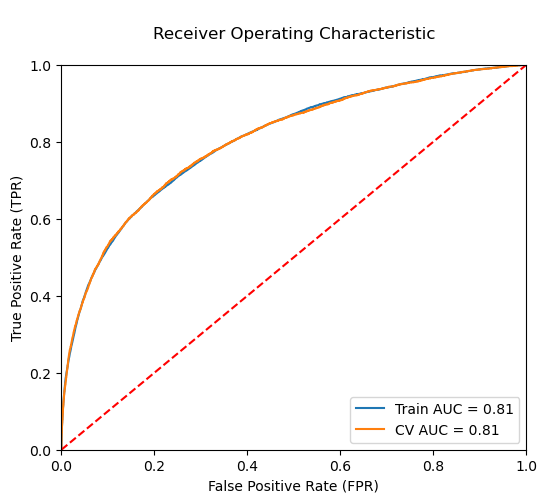

In [24]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

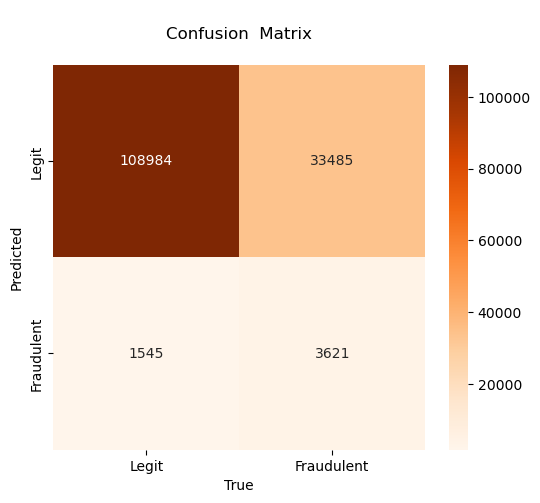

In [25]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, lr_test_proba)

draw_confusion_matrix(y_test, test_pred)

###  Decision Tree

In [26]:
dt =  DecisionTreeClassifier(random_state=3, class_weight='balanced')
dt.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=3)

In [27]:
dt_train_proba = dt.predict_proba(X_train2)[:,1]
dt_test_proba = dt.predict_proba(X_test2)[:,1]

In [28]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, dt_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, dt_test_proba)

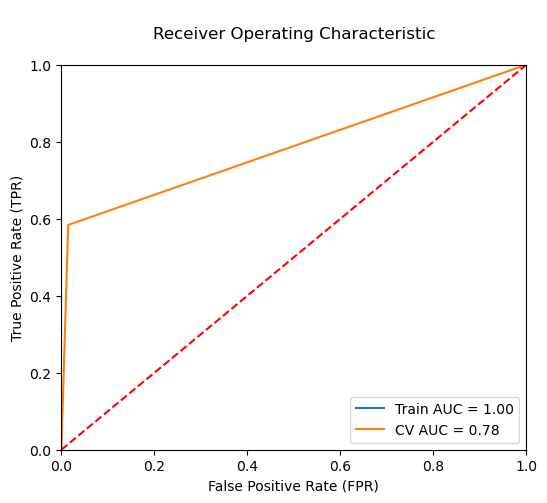

In [29]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

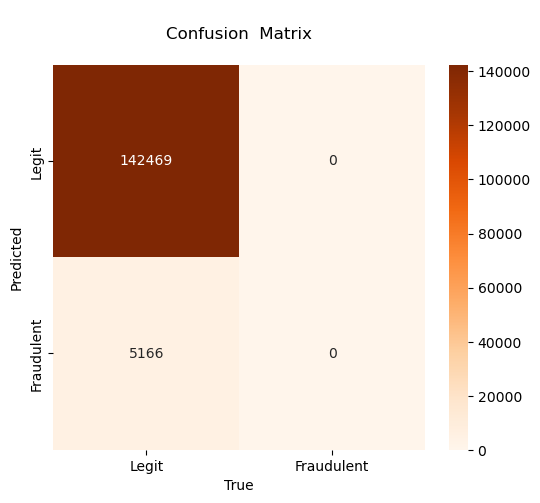

In [30]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, dt_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [45]:
y_pred=dt.predict(X_test2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    142469
           1       0.59      0.58      0.59      5166

    accuracy                           0.97    147635
   macro avg       0.79      0.78      0.79    147635
weighted avg       0.97      0.97      0.97    147635



### Random Forest

In [31]:
rf =  RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
rf.fit(X_train2, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=3)

In [32]:
rf_train_proba = rf.predict_proba(X_train2)[:,1]
rf_test_proba = rf.predict_proba(X_test2)[:,1]

In [33]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, rf_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, rf_test_proba)

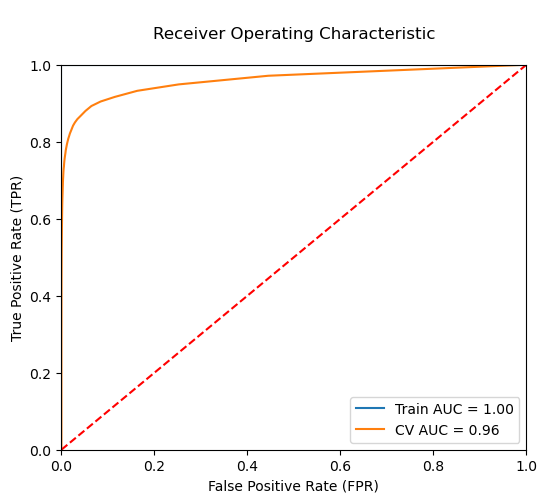

In [34]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

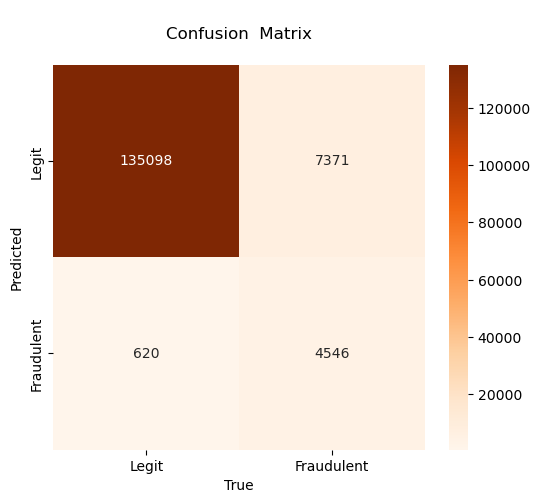

In [35]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, rf_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [44]:
y_pred=rf.predict(X_test2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.96      0.55      0.70      5166

    accuracy                           0.98    147635
   macro avg       0.97      0.78      0.85    147635
weighted avg       0.98      0.98      0.98    147635



### XGBoost

In [36]:
weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [49]:
xgb =  XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
xgb.fit(X_train3, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27.579918693940762,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [50]:
xgb1 =  XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
xgb1.fit(X_train1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27.579918693940762,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [51]:
xgb_train_proba = xgb.predict_proba(X_train3)[:,1]
xgb_test_proba = xgb.predict_proba(X_test3)[:,1]

In [52]:
xgb_train_proba1 = xgb1.predict_proba(X_train1)[:,1]
xgb_test_proba1 = xgb1.predict_proba(X_test1)[:,1]

In [53]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, xgb_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, xgb_test_proba)

In [54]:
train_fpr1, train_tpr1, train_threshold1, train_roc_auc1 = tpr_fpr_threshold_auc(y_train, xgb_train_proba1)
test_fpr1, test_tpr1, test_threshold1, test_roc_auc1 = tpr_fpr_threshold_auc(y_test, xgb_test_proba1)

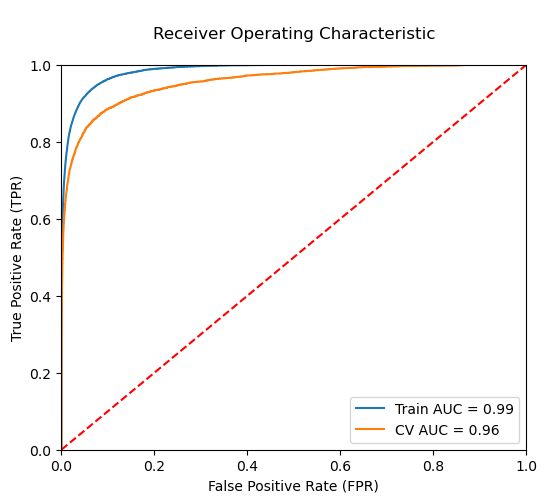

In [55]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

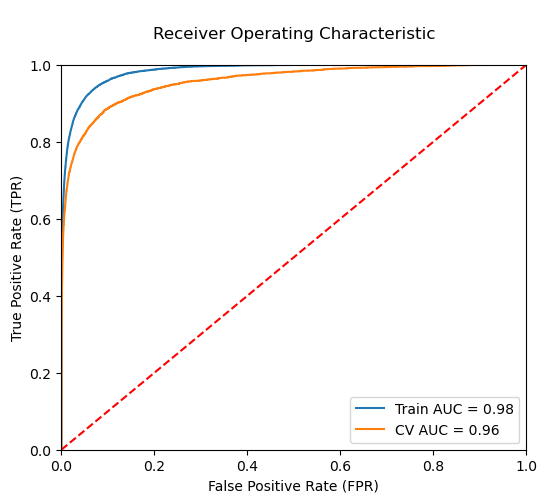

In [56]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr1, train_tpr1, train_roc_auc1, test_fpr1, test_tpr1, test_roc_auc1)

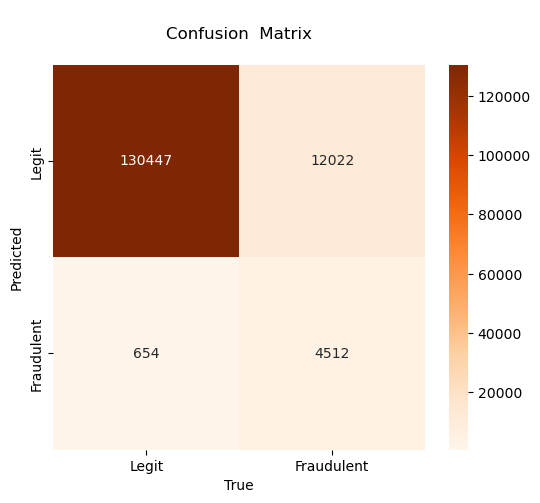

In [57]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, xgb_test_proba)

draw_confusion_matrix(y_test, test_pred)

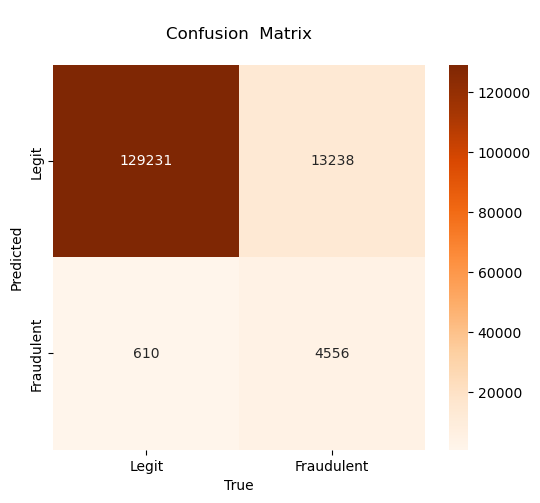

In [58]:
best_thr1 = best_threshold(test_threshold1, test_tpr1, test_fpr1)
test_pred1 = class_label(best_thr1, xgb_test_proba1)

draw_confusion_matrix(y_test, test_pred1)

In [59]:
y_pred=xgb.predict(X_test3)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97    142469
           1       0.34      0.84      0.48      5166

    accuracy                           0.94    147635
   macro avg       0.67      0.89      0.72    147635
weighted avg       0.97      0.94      0.95    147635



In [60]:
y_pred1=xgb.predict(X_test1)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142469
           1       0.00      0.00      0.00      5166

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635



In [43]:
# save xgb model
saving_path_name = "./xgb_model"
saved_filepath = xgb.save_model(saving_path_name)